### Deep Hedging

Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Evaluation of how good $V_{T}$ hedge $Z$ by convex risk measure $\rho$
$$
\rho(-Z + V_T).
$$
By cash invariant of convex risk measure we have 
$$
\rho(-Z + V_T) = \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0,
$$
which means that the risk increase at maturity $T$ is indeed how much we subtract at time $0$, so implicitly we are actually compare the discounted value. This idea is also reflected in the definition of OCE measure below (a special case of convex risk measure).

Our goal is to find the best strategy $H$ under $\rho$:
$$
\pi(-Z) = \min_{H} \rho\Big((H\cdot S)_T - C_T - Z\Big) + V_0.
$$
In particular we choose OCE measure 
$$
\rho(X) = \inf_{w \in \mathbb{R}}\{w + \mathbb{E}_{\mathbb{P}}[l(-X-w)]\}
$$
where $l(x)$ represent risk (with $u$ to be utility function).
- Entropic risk measure: $l(x) = \exp(\lambda x) - \frac{1}{\lambda}(1+\log\lambda)$, $\lambda > 0$
\begin{align*}
\rho(X) &= \frac{1}{\lambda}\log\Big(\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)\\
\omega^{*} &= \frac{1}{\lambda}\log\Big(\lambda\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)
\end{align*}

- Expected shortfall: $l(x) = \frac{1}{1-\alpha}\max(x,0)$, $\alpha \in (0,1)$
\begin{align*}
\rho(X) &= \frac{1}{1-\alpha}\int_{0}^{1-\alpha}\mathrm{VaR}_{\gamma}(X)d\gamma\\
\omega^{*} &= -\mathrm{VaR}_{1-\alpha}(X)
\end{align*}

- Square loss: $l(x) = \frac{x^2 + 1}{2}$
\begin{align*}
\rho(X) &= \frac{1}{2}\mathrm{Var}_{\mathbb{P}}[X] -  \mathbb{E}_{\mathbb{P}}[X] \\
\omega^{*} &= -\mathbb{E}_{\mathbb{P}}[X]
\end{align*}
At the end we specify $V_0 = \omega^{*}$ to be the initial wealth i.e. the price of payoff. 

Numerically, we are solving the following minimization problem 
$$
\rho(X) = \inf_{H \in \mathcal{NN}}\inf_{V_0 \in \mathbb{R}}\Big\{V_0 + \mathbb{E}_{\mathbb{P}}\Big[l\big(Z + C_T - V_T \big)\big)\Big]\Big\}
$$

- ! Price process need to be discounted



In [1]:
import numpy as np
import torch

from math import ceil
import matplotlib.pyplot as plt

from neuralhedge.nn import datahedger, contigent, mlp, loss, blackschole
from neuralhedge.nn.loss import ExpectedShortfall
from neuralhedge.market import stochastic, markets
from neuralhedge._utils.plotting import plot_pnl, plot_history, plot_data_set, plot_hedge
from importlib import reload


### Black-Scholes & European Call

In [2]:
deep = False
n_paths = 50000
step_size = 1/365
maturity = 30/365
n_steps = ceil(maturity / step_size)
initial_value = 100.
strike = initial_value
mu = 0.0
sigma = 0.2

blackscholesmarket = stochastic.BlackScholes(mu = mu, 
                            sigma = sigma,
                            n_paths = n_paths,
                            n_steps = n_steps,
                            step_size = step_size)
blackscholesmarket.stimulate(initial_value = initial_value)
option = contigent.EuropeanVanilla(strike = strike)

paths = blackscholesmarket.prices     # (n_paths, n_steps+1, n_asset)
if deep:
    information = torch.log(blackscholesmarket.prices)
else:
    information = torch.cat([
        torch.log(blackscholesmarket.prices),
        blackscholesmarket.times_inverse
        ], axis = -1)
    
payoff = option.payoff(blackscholesmarket.prices)   # (n_paths, n_steps+1, 1)

n_asset = paths.shape[-1]
n_feature = information.shape[-1]
data_set = [paths, information, payoff]


dataset_market = datahedger.MarketDataset(data_set)

Shape of paths:  torch.Size([50000, 31, 1])
Shape of information:  torch.Size([50000, 31, 2])
Shape of payoff:  torch.Size([50000, 31, 1])


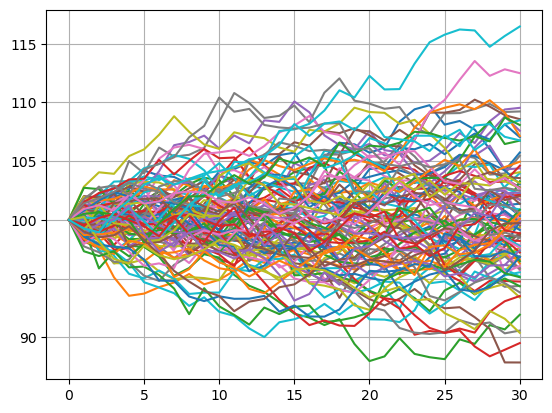

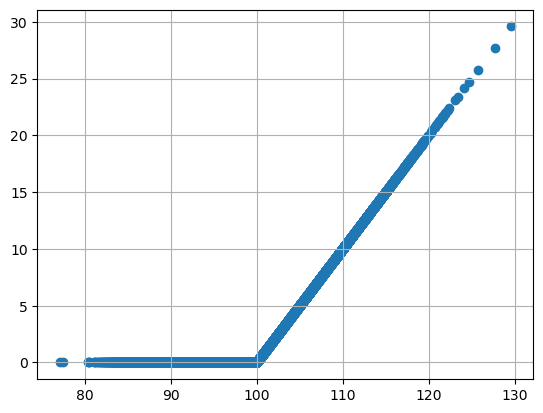

True price is:  tensor(2.2889)


In [3]:
# data_set, dataset_market = markets.BlackScholesTestMarket()
paths, information, payoff = data_set
n_asset = paths.shape[-1]
plot_data_set(data_set)
true_price = payoff[:,-1].mean().numpy()
print('True price is: ', payoff[:,-1].mean())

### Data Hedger


Price:  2.2889028


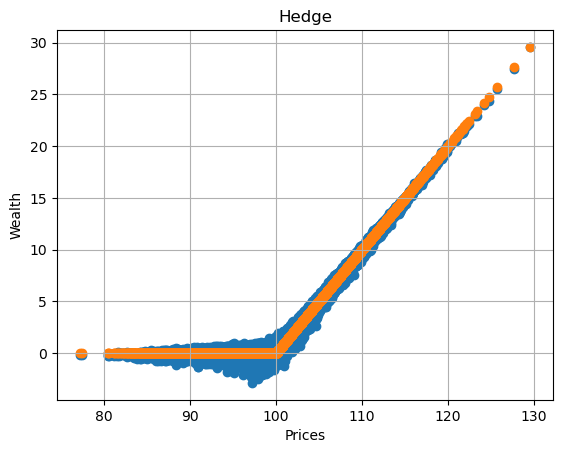

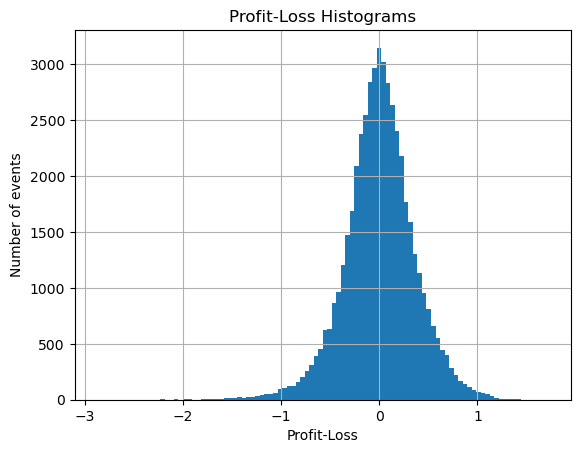

In [4]:
model = blackschole.BlackScholesDelta(sigma=sigma,strike=strike)
hedger = datahedger.Hedger(model) 
plot_hedge(hedger, data_set, price = true_price)
# wealth = hedger(data_set)

#### Entropic Risk Measure

Loss=2.3343307971954346: 100%|██████████| 80/80 [02:33<00:00,  1.92s/it]


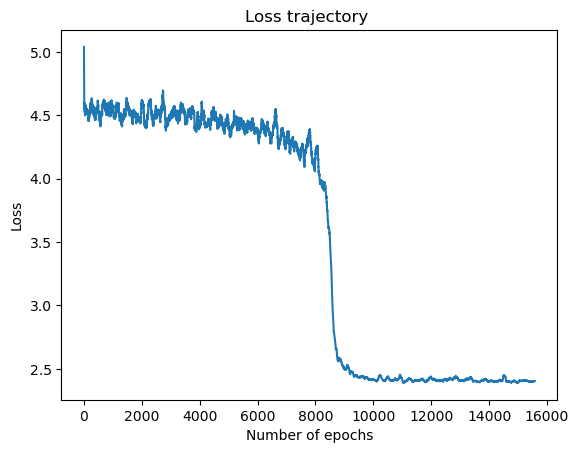

Price:  [2.4596508]


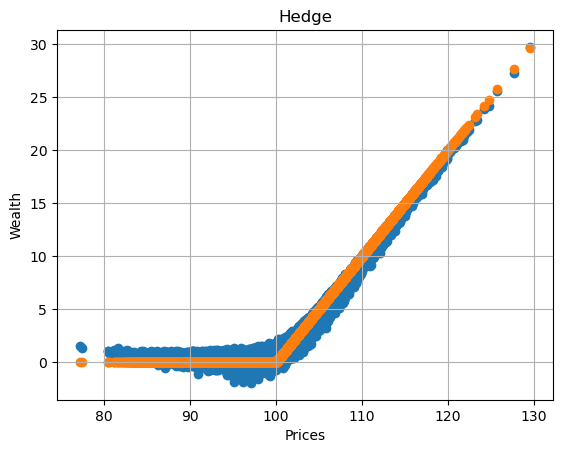

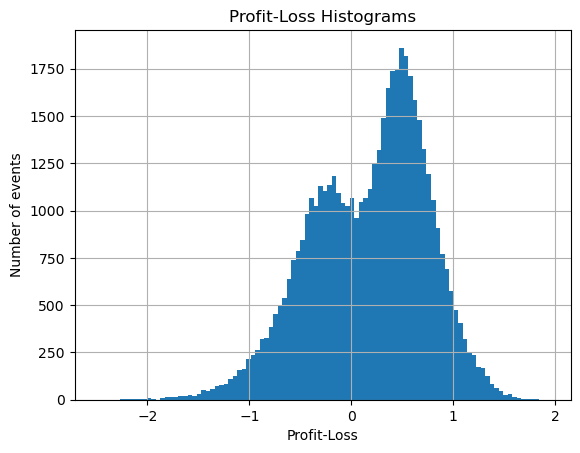

In [8]:
reload(datahedger)
model = mlp.NeuralNetSequential(n_output = n_asset)
hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market, EPOCHS=80) 

plot_history(history)
plot_hedge(hedger, data_set)

#### Square loss

Loss=2.50829815864563: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]  


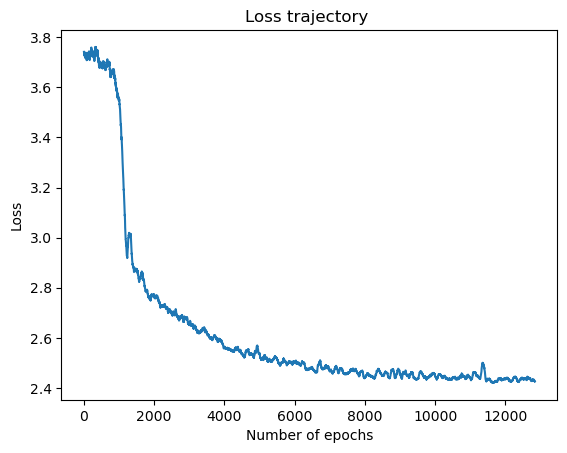

Price:  2.2884614


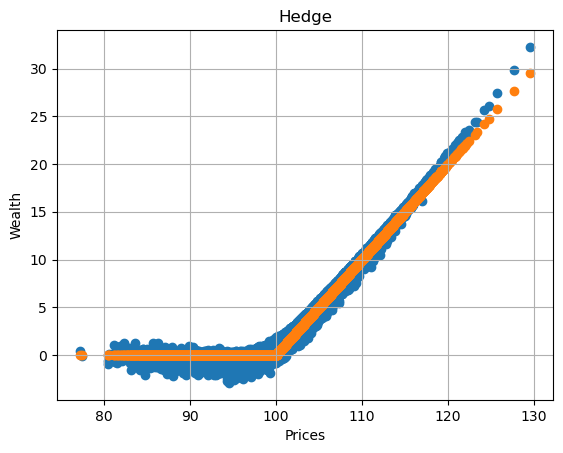

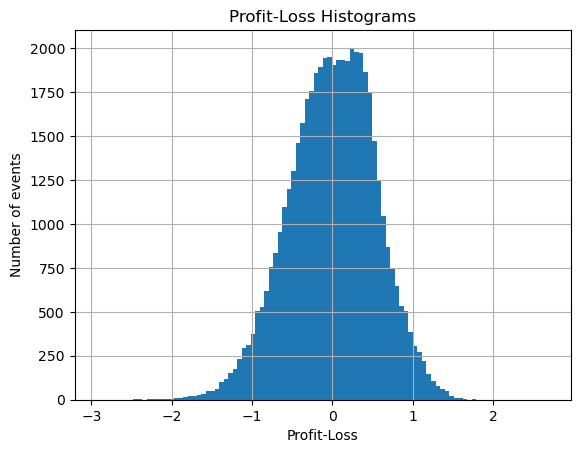

In [6]:
history = hedger.fit(dataset_market, EPOCHS=66,criterion=loss.SquareMeasure()) 
plot_history(history)
plot_hedge(hedger, data_set)

#### Expected shorfall

In [9]:
# alpha = 0.5
# q = 1-alpha
# history = hedger.fit(dataset_market, EPOCHS=66,criterion=loss.ExpectedShortfall(q)) 
# plot_history(history)
# plot_hedge(hedger, data_set)

In [10]:
# alpha = 0.99
# q = 1-alpha
# history = hedger.fit(dataset_market, EPOCHS=66,criterion=loss.ExpectedShortfall(q)) 
# plot_history(history)
# plot_hedge(hedger, data_set)

#### OCE

### Deep Hedger

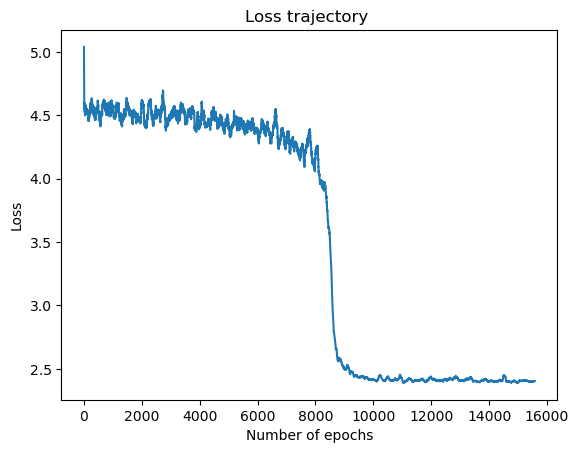

Price:  [2.9366775]


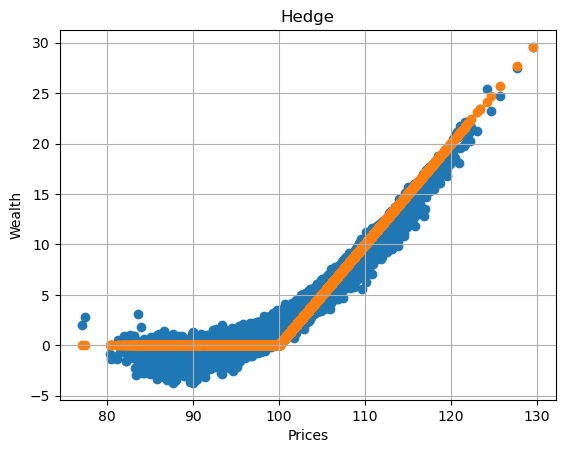

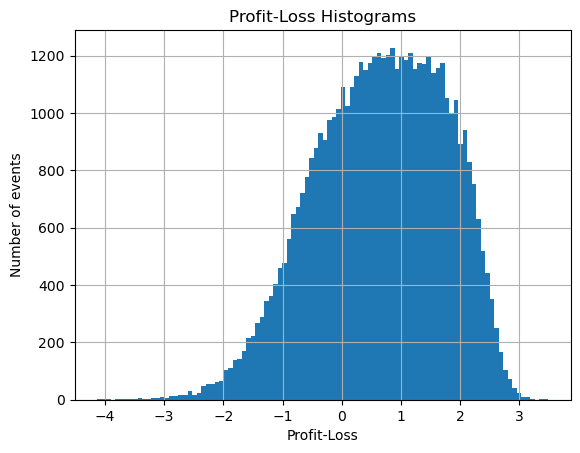

In [12]:
n_steps = paths.shape[1]-1
models = [mlp.NeuralNet(n_output = n_asset) for t in range(n_steps)]
hedger = datahedger.DeepHedger(models) 
history = hedger.fit(dataset_market, EPOCHS=66 ,lr = 0.01)
plot_history(history)
plot_hedge(hedger, data_set)


### Heston Model (Multi-Asset)

Shape of paths:  torch.Size([50000, 31, 2])
Shape of information:  torch.Size([50000, 31, 3])
Shape of payoff:  torch.Size([50000, 31, 1])


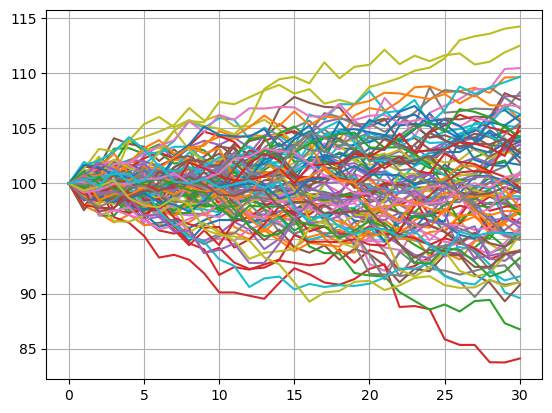

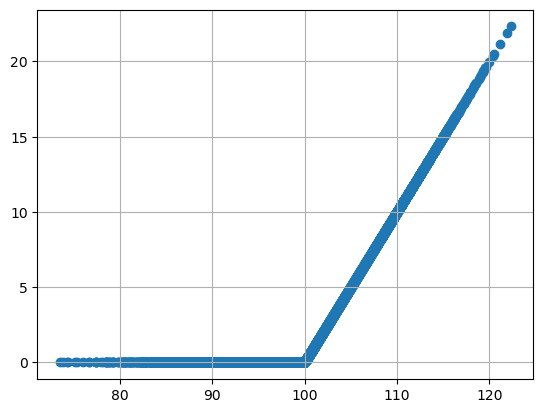

True price is:  tensor(2.2398)


In [13]:
data_set, dataset_market = markets.HestonTestMarket()
paths, information, payoff = data_set
n_asset = paths.shape[-1]
plot_data_set(data_set)
print('True price is: ', payoff[:,-1].mean())

Loss=2.419553756713867: 100%|██████████| 66/66 [06:43<00:00,  6.11s/it] 


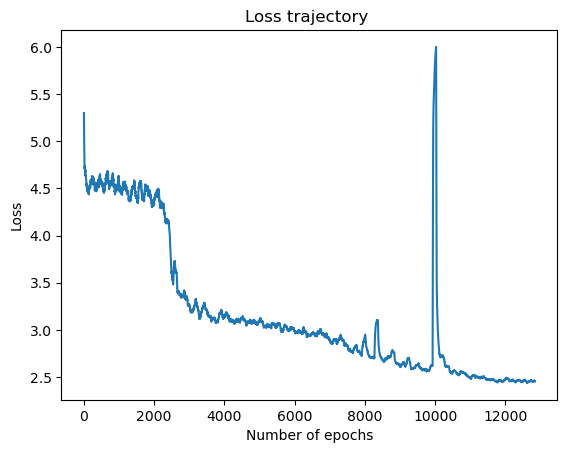

Price:  [2.410517]


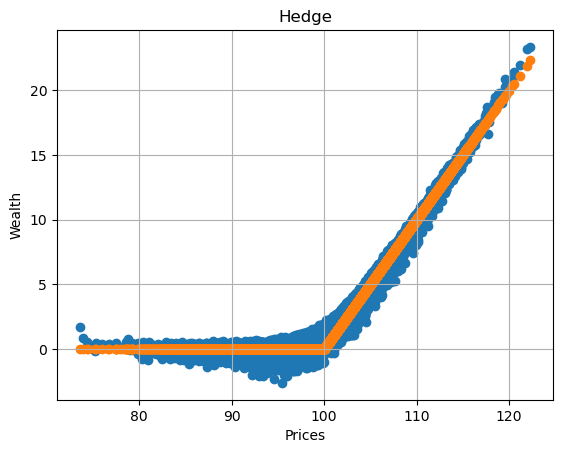

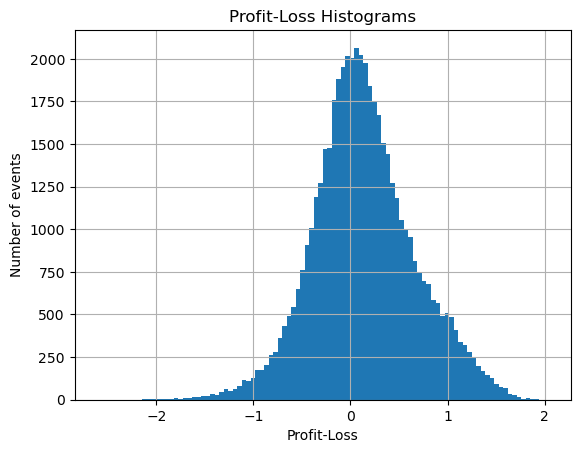

In [14]:
model = mlp.NeuralNetSequential(n_output = n_asset)
hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market, EPOCHS=66) 
plot_history(history)
plot_hedge(hedger, data_set)